In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import time
import sys
import gc

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# y_vocab preprocess

In [3]:
import _pickle
y_vocab = _pickle.load(open('./data_org/y_vocab.py3.cPickle', 'rb'))
y_vocab['43>109>1576>-1']
print(len(y_vocab))

token_to_cate = {}
for it in y_vocab.items():
     token_to_cate[it[1]] = it[0]

4215


In [4]:
def onehot(data_y, output_dim=4215): # 4215개
    # y-label to one-hot encoding
    y_tmp = np.zeros([len(data_y), output_dim], dtype=np.int8)
    y_tmp[np.arange(len(data_y)), data_y] = 1
    data_y = y_tmp

    return data_y

---
# char x_vocab

In [5]:
x_vocab = pd.read_csv('./data_org/char.csv', encoding='utf8')
x_vocab = x_vocab.as_matrix()

In [6]:
#  3000개 = 2998 + unk + pad
x_vocab = {
    e[0]:i  for i,e in enumerate(x_vocab[:2998])
}

In [7]:
x_vocab['<PAD>'] = 2998
x_vocab['<UNK>'] = 2999

In [8]:
len(x_vocab.values())
# x_vocab.v()
# x_vocab

3000

In [9]:
%%time
sentence = "plt.plot(x_range, val_accuracies,'-g', label='Validation'꼬ㅑ재)"
print([x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence])

[77, 19, 23, 100, 77, 19, 10, 23, 11, 162, 91, 15, 7, 22, 64, 5, 138, 0, 166, 7, 19, 91, 7, 43, 43, 57, 15, 7, 43, 13, 5, 27, 138, 614, 28, 64, 614, 138, 0, 19, 7, 120, 5, 19, 1037, 614, 121, 7, 19, 13, 58, 7, 23, 13, 10, 22, 614, 580, 2999, 292, 12]
Wall time: 3 ms


# word preprocess

In [10]:
def set_train_data(chunk_no):
    path_x = './tmp/data_0%d.h5'%(chunk_no)
    path_y = './tmp/data_y_0%d.csv'%(chunk_no)
    h = h5py.File(path_x, 'r')
    y = pd.read_csv(path_y, header=None, dtype=np.int32)
    y=onehot(y[0])

    # # validation data
    # path_x = './data_org/val.h5'
    # path_y = './tmp/data_y_val.csv'
    # h = h5py.File(path_x, 'r')
    # y = pd.read_csv(path_y, header=None)
    # y=onehot(y[0])

    mode = 'train'
    cols = ['pid', 'product', 'model', 'brand', 'maker', 'price', 'updttm', 'bcateid', 'mcateid', 'scateid', 'dcateid']
    data = {
        c: h[mode][c] for c in cols
    }
    df = pd.DataFrame(data)

    for i in ['pid', 'product', 'model', 'brand', 'maker', 'updttm']:
        df[i] = df[i].apply(lambda x: x.decode('utf8'))

    df2 = pd.DataFrame(h[mode]['img_feat'][:])
    
    h.close()
    return df, df2, y

In [11]:
# 피처 데이터, 레이블, 미니배치 갯수, random sampling
import random
import h5py
import mmh3

seq_len=128
random.seed(2018)
def getMiniBatch3(xc, xm, xe, y, n):
    assert len(xc) == len(y)
    assert len(xm) == len(y)
        
    rand_idx = random.sample(list(range(len(y))), n)    
    xc_ = xc.iloc[rand_idx] # word
    xm_ = xm.iloc[rand_idx] # image
    xe_ = xe.iloc[rand_idx] # else
    
    xe_ = np.array(xe_).transpose()[0].astype(np.int32)
    xe_ = np.array([(1,i) if not np.isnan(i) else (0,0) for i in np.log10(xe_)])
    
    y_ = y[rand_idx]
    
    # df to data - char to token
    data_x_fw = []
    data_x_bw = []
    for i in xc_.as_matrix():
        sentence = ' '.join(i)
        sentence = list(sentence)
        kkk = sentence
        # hash --> word to id
        word_ids_fw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
        word_ids_fw = np.pad(word_ids_fw, (0,seq_len-len(word_ids_fw)), 'constant', constant_values=(2998)) # pad=2998
        data_x_fw.append(word_ids_fw)
        # revcerse
        sentence.reverse()
        word_ids_bw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
        word_ids_bw = np.pad(word_ids_bw, (0,seq_len-len(word_ids_bw)), 'constant', constant_values=(2998)) # pad=2998
        data_x_bw.append(word_ids_bw)
        
        
    return np.array(data_x_fw), np.array(data_x_bw), np.array(xm_), np.array(xe_), np.array(y_)

In [112]:
%%time
X_fw, X_bw, Xm_, Xp_, Y_ = getMiniBatch3(df[['product', 'brand', 'model', 'maker']], df2,
              df[['price', 'updttm']], y, batch_size)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


Wall time: 192 ms


---
## set val data

In [12]:
def set_val_data():
    path_x = './tmp/data_val.h5'
    path_y = './tmp/data_y_val.csv'
    h = h5py.File(path_x, 'r')
    y = pd.read_csv(path_y, header=None, dtype=np.int32)
    y = y.sample(frac=1, random_state=2018) # shuffle y
    y = onehot(y[0])
    
    start_idx = 0 
    mode = 'val'
    cols = ['pid', 'product', 'model', 'brand', 'maker', 'price', 'updttm', 'bcateid', 'mcateid', 'scateid', 'dcateid']
    data = {
        c: h[mode][c] for c in cols
    }
    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=2018) # shuffle df

    for i in ['pid', 'product', 'model', 'brand', 'maker', 'updttm']:
        df[i] = df[i].apply(lambda x: x.decode('utf8'))

    df2 = pd.DataFrame(h[mode]['img_feat'][:])
    df2 = df2.sample(frac=1, random_state=2018) # shuffle df2
    
    h.close()
    return df, df2, y

In [44]:
#밸리데이션용으로
df_val, df2_val, Y_val_all = set_val_data()
# seq_len=100

# df to data - char to token
data_x_fw = []
data_x_bw = []
for i in tqdm(list(zip(df_val['product'], df_val['brand'], df_val['model'], df_val['maker']))):
    sentence = ' '.join(i)
    sentence = list(sentence)    
    # hash --> word to id
    word_ids_fw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
    word_ids_fw = np.pad(word_ids_fw, (0,seq_len-len(word_ids_fw)), 'constant', constant_values=(2998)) # pad=2998
    data_x_fw.append(word_ids_fw)
    # revcerse
    sentence.reverse()
    word_ids_bw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
    word_ids_bw = np.pad(word_ids_bw, (0,seq_len-len(word_ids_bw)), 'constant', constant_values=(2998)) # pad=2998
    data_x_bw.append(word_ids_bw)
    
X_fw_val = np.array(data_x_fw)[:2000]
X_bw_val = np.array(data_x_bw)[:2000]
Xm_val = np.array(df2_val)[:2000]
Xp_val = np.array(df_val[['price', 'updttm']])
Xp_val = Xp_val.transpose()[0].astype(np.int32)
Xp_val = np.array([(1,i) if not np.isnan(i) else (0,0) for i in np.log10(Xp_val)])[:2000]
# Xp_val = np.expand_dims(Xp_val, axis=1)
Y_val = Y_val_all[:2000]

A Jupyter Widget

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


In [45]:
print(X_fw_val.shape, X_bw_val.shape, Xm_val.shape, Xp_val.shape, Y_val.shape)

(2000, 128) (2000, 128) (2000, 2048) (2000, 2) (2000, 4215)


# make model

In [39]:
# make DAG
tf.reset_default_graph()
tf.set_random_seed(2018)

# train Parameters
output_dim = 4215 # 1번 트레이닝셋만

epoch = 100
# seq_len=100
vocabulary_size = len(x_vocab) # x_vocab length
# embedding_size = 512
embedding_size = 256
features = 200


# =============================================================================
is_training = tf.placeholder(tf.bool) # 배치놈 위한 트레이닝/테스트 구분 불리언

Y = tf.placeholder(tf.int16, [None, output_dim], name="label")
lr = tf.placeholder(tf.float32, [], name='learning_rate')
keep_prob = tf.placeholder(tf.float32, [], name="keep_prob"
                          )

#  embedding
X_fw = tf.placeholder(tf.int32, [None, seq_len], name="word_tokens_fw") 
X_bw = tf.placeholder(tf.int32, [None, seq_len], name="word_tokens_bw") 
word_embeddings = tf.get_variable("word_embeddings",
    [vocabulary_size, embedding_size], initializer=tf.contrib.layers.xavier_initializer())
embedded_fw = tf.nn.embedding_lookup(word_embeddings, X_fw) # batch * seq * embeddding
embedded_bw = tf.nn.embedding_lookup(word_embeddings, X_bw) # batch * seq * embeddding
    
# image features
Xm = tf.placeholder(tf.float32, [None, 2048], name="img_feat") 

# price feature
Xp = tf.placeholder(tf.float32, [None, 2], name="price") 

"""
#  dropout layer
def _sequence_dropout(step_inputs, keep_prob):
        # apply dropout to each input
        # input : a list of input tensor which shape is [None, input_dim]
        with tf.name_scope('sequence_dropout') as scope:
            step_outputs = []
            for t, _input in enumerate(step_inputs):
                step_outputs.append( tf.nn.dropout(_input, keep_prob) )
        return step_outputs

embedded_fw = tf.unstack(embedded_fw, axis=1)
step_inputs = _sequence_dropout(embedded_fw, keep_prob) # seq * batch * embedding

#  FCN layer
doc_mean = tf.reduce_mean(step_inputs, axis=0) # batch * embedding (mean)
# hint = tf.placeholder(tf.float32, [None, 609], name='hint') # previous category
# bf_lenear = tf.concat([doc_mean, hint], axis=1) # batch * (embediing + hint)
# bf_lenear = tf.nn.dropout(bf_lenear, keep_prob)
"""

embedded_fw = tf.reshape(embedded_fw, [-1, seq_len, embedding_size, 1])
embedded_bw = tf.reshape(embedded_bw, [-1, seq_len, embedding_size, 1])
# CNN layer
def char_cnn(no, embedded, name):
  F = tf.get_variable(name, [no, embedding_size, 1, features], 
                     initializer=tf.contrib.layers.xavier_initializer()) # (row, column, channel, kernels)
  L = tf.nn.conv2d(embedded, F, strides=[1, 1, 1, 1], padding='VALID')
  L = tf.layers.batch_normalization(L, training=is_training)
  L = tf.nn.tanh(L)
  return L

C2f = char_cnn(2, embedded_fw, name='2gram-filter-fw') # batch, seq-1, 1, filters
C2fm = tf.nn.max_pool(C2f, ksize=[1, seq_len-(2-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
C2b = char_cnn(2, embedded_bw, name='2gram-filter-bw')

C3f = char_cnn(3, embedded_fw, name='3gram-filter-fw')
C3fm = tf.nn.max_pool(C3f, ksize=[1, seq_len-(3-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
C3b = char_cnn(3, embedded_bw, name='3gram-filter-bw')

C4f = char_cnn(4, embedded_fw, name='4gram-filter-fw')
C4fm = tf.nn.max_pool(C4f, ksize=[1, seq_len-(4-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
C4b = char_cnn(4, embedded_bw, name='4gram-filter-bw')

# C5f = char_cnn(5, embedded_fw, name='5gram-filter-fw')
# C5fm = tf.nn.max_pool(C5f, ksize=[1, seq_len-(5-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
# C5b = char_cnn(5, embedded_bw, name='5gram-filter-bw')

# 1*1 conv
def one_cnn(fw, bw, name):
    Concat = tf.concat([fw, bw], 3)
    F = tf.get_variable(name, [1, 1, 2*features, 1], 
                     initializer=tf.contrib.layers.xavier_initializer()) # (row, column, channel, kernels)
    L = tf.nn.conv2d(Concat, F, strides=[1, 1, 1, 1], padding='VALID')
    L = tf.layers.batch_normalization(L, training=is_training)
    L = tf.nn.tanh(L)
    return L

C2all = one_cnn(C2f, C2b, '2gram-1by1-filter')
C3all = one_cnn(C3f, C3b, '3gram-1by1-filter')
C4all = one_cnn(C4f, C4b, '4gram-1by1-filter')
C_all = tf.concat([C2all, C3all, C4all], 1)
C_all = tf.squeeze(C_all, axis=[2,3]) # (?, seq_len*3 - some)

conv_list = [C2fm, C3fm, C4fm]
C_cat = tf.concat(conv_list, 3) # (?, 1, 1, features*3) --> to attention
C_flat = tf.reshape(C_cat, [-1, len(conv_list)*features]) # (?, features*3)
C_flat = tf.contrib.layers.fully_connected(C_flat, len(conv_list)*50, activation_fn=tf.nn.elu) #(?, 50*3)

# 이미지
# Xm = tf.nn.dropout(Xm, keep_prob)
Xm2 = tf.contrib.layers.fully_connected(Xm, features, activation_fn=tf.nn.elu) # (?, features*3)

# dot product attention
Xm2_3d = tf.reshape(Xm2, [-1, features, 1])
C_cat_3d = tf.reshape(C_cat, [-1, len(conv_list), features])
A = tf.matmul(C_cat_3d, Xm2_3d) # ?, 3, 1
A_soft = tf.nn.softmax(A, axis=1)
ww = A_soft*C_cat_3d # ?, 3, 200
att = tf.reduce_sum(ww, axis=1) # ?, 200

C_flat_final = tf.concat([C_flat, C_all, att, Xm2, Xp], axis=1)

# 오캄의 면도날... 굳이 없어도 되는 레이어인듯
# L_linear = tf.contrib.layers.fully_connected(C_flat_final, 512, activation_fn=tf.nn.relu)
# L_linear = tf.nn.dropout(L_linear, keep_prob)
L_linear = tf.nn.dropout(C_flat_final, keep_prob)


# Y_pred = tf.contrib.layers.fully_connected(bf_lenear, output_dim, activation_fn=tf.nn.relu)  # We use the last cell's output
L_linear2 = tf.contrib.layers.fully_connected(L_linear, 1024, activation_fn=tf.nn.elu)  # We use the last cell's output
Y_pred = tf.contrib.layers.fully_connected(L_linear2, output_dim, activation_fn=None)  # We use the last cell's output


# # image feature
# X = tf.placeholder(tf.float32, [None, len(data_x[0])], name="img_feat")
# X = tf.nn.dropout(X, keep_prob)
# Y_pred = tf.contrib.layers.fully_connected(X, output_dim,
#                                            activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())  # We use the last cell's output

# for batch norm
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# optimize
cost =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=Y_pred, labels=Y, name='cross_entropy'))
optimizer = tf.train.AdamOptimizer(lr)
with tf.control_dependencies(update_ops):
    train_step = optimizer.minimize(cost)

# prediction
predicted = tf.argmax(Y_pred, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

# saver
name_to_var_map = {var.op.name: var for var in tf.global_variables()}
saver = tf.train.Saver(name_to_var_map, name='my_saver', max_to_keep=30)

# train/save

In [ ]:
%%time 
gc.collect()

if 'sess' in globals(): sess.close()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
val_costs=[]
ckpt_path = './small_model/small'
# lr_start = 0.005
lr_start = 0.008
batch_size = 1024
# iter_per_epoch = int(len(Y_train)/batch_size)
iter_per_epoch = int(812650/batch_size)

chunk_no = 0
chunk_no_pre = -1

start = time.time()
print('total iter is %d * %d' %(epoch, iter_per_epoch))
for e in range(epoch):
# 데이터 청크 같으면 다시 로드 안하는 코드 넣기, 청크 순서도 고려해보기
    # epoch별 데이터 청크 로드
#     chunk_no = int((e+6)/2)%10  # int((e + shift_epoch*2)/2)%chunk_range+1
    chunk_no = int(e/2)%10
    if chunk_no!=chunk_no_pre:
        df, df2, y = set_train_data(chunk_no)
        gc.collect()
    chunk_no_pre = chunk_no
    
    print('********** %d epoch started: lr-%g, chunk_no-%d **********'%(e, lr_start, chunk_no))
    for i in range(iter_per_epoch):
        X_fw_, X_bw_, Xm_, Xp_, Y_ = getMiniBatch3(df[['product', 'brand', 'model', 'maker']], df2,
                      df[['price', 'updttm']], y, batch_size)
        train_step.run(feed_dict={X_fw:X_fw_, X_bw:X_bw_, Xm:Xm_, Xp:Xp_, Y:Y_, lr:lr_start, keep_prob:0.5, is_training:True})

    #   아래에 결과 프린트용
        if i % 50 == 0:   
            train_accuracy = accuracy.eval(feed_dict={X_fw:X_fw_, X_bw:X_bw_, Xm:Xm_, Xp:Xp_, Y:Y_, lr:lr_start, keep_prob:0.5, is_training:False})
            val_accuracy, val_cost = sess.run([accuracy, cost], feed_dict={X_fw:X_fw_val, X_bw:X_bw_val, Xm:Xm_val, Xp:Xp_val, Y:Y_val, keep_prob:1, is_training:False})

            if lr_start>0.005: lr_start = lr_start*0.94
            elif lr_start>0.0005: lr_start = lr_start*0.998 # lr annealing
            else :lr_start = lr_start*0.999
            
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_costs.append(val_cost)
            x_range.append(i+ iter_per_epoch*e)
            end = time.time()
            print('step %d: acc_tr %.5f, acc_val %.5f, cost_val %.5f, \t//%.3f sec' % (i, train_accuracy, val_accuracy, val_cost, end-start))
            start = time.time()
            
    saver.save(sess, ckpt_path, global_step=i+ iter_per_epoch*e)
    print('model saved: %s-%d'%(ckpt_path, i+ iter_per_epoch*e))

total iter is 100 * 793
********** 0 epoch started: lr-0.008, chunk_no-0 **********


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


step 0: acc_tr 0.00977, acc_val 0.00450, cost_val 8.49656, 	//19.004 sec
step 50: acc_tr 0.02051, acc_val 0.01100, cost_val 9.69483, 	//27.291 sec
step 100: acc_tr 0.05664, acc_val 0.05500, cost_val 7.82277, 	//28.015 sec
step 150: acc_tr 0.06543, acc_val 0.06100, cost_val 7.15373, 	//27.466 sec
step 200: acc_tr 0.08887, acc_val 0.08400, cost_val 6.56280, 	//27.976 sec
step 250: acc_tr 0.10059, acc_val 0.10350, cost_val 6.13702, 	//27.166 sec
step 300: acc_tr 0.14062, acc_val 0.11400, cost_val 5.99451, 	//27.914 sec
step 350: acc_tr 0.14746, acc_val 0.13650, cost_val 5.79197, 	//27.296 sec
step 400: acc_tr 0.16699, acc_val 0.16400, cost_val 5.56242, 	//28.221 sec
step 450: acc_tr 0.17090, acc_val 0.17250, cost_val 5.46717, 	//27.230 sec
step 500: acc_tr 0.21973, acc_val 0.20350, cost_val 5.15095, 	//27.923 sec
step 550: acc_tr 0.25586, acc_val 0.20550, cost_val 4.95821, 	//27.164 sec
step 600: acc_tr 0.22754, acc_val 0.22650, cost_val 4.85071, 	//28.094 sec
step 650: acc_tr 0.26855, ac

step 250: acc_tr 0.48438, acc_val 0.47550, cost_val 3.20845, 	//27.839 sec
step 300: acc_tr 0.53320, acc_val 0.47950, cost_val 3.15782, 	//27.101 sec
step 350: acc_tr 0.51758, acc_val 0.46950, cost_val 3.17517, 	//27.761 sec
step 400: acc_tr 0.48047, acc_val 0.46250, cost_val 3.23013, 	//27.479 sec
step 450: acc_tr 0.53418, acc_val 0.49450, cost_val 3.18052, 	//27.792 sec
step 500: acc_tr 0.48828, acc_val 0.46950, cost_val 3.27279, 	//27.091 sec
step 550: acc_tr 0.50488, acc_val 0.48750, cost_val 3.15543, 	//27.765 sec
step 600: acc_tr 0.51855, acc_val 0.49050, cost_val 3.17818, 	//27.081 sec
step 650: acc_tr 0.52344, acc_val 0.47550, cost_val 3.27496, 	//28.296 sec
step 700: acc_tr 0.51953, acc_val 0.48150, cost_val 3.11380, 	//27.172 sec
step 750: acc_tr 0.50977, acc_val 0.48650, cost_val 3.21925, 	//27.844 sec
model saved: ./small_model/small-5550
********** 7 epoch started: lr-0.00381303, chunk_no-3 **********
step 0: acc_tr 0.50586, acc_val 0.51100, cost_val 3.10676, 	//25.024 sec

step 500: acc_tr 0.52832, acc_val 0.52800, cost_val 2.73413, 	//27.129 sec
step 550: acc_tr 0.55566, acc_val 0.53400, cost_val 2.84222, 	//27.843 sec
step 600: acc_tr 0.55273, acc_val 0.51700, cost_val 2.82151, 	//27.182 sec
step 650: acc_tr 0.54492, acc_val 0.53100, cost_val 2.85348, 	//28.130 sec
step 700: acc_tr 0.57520, acc_val 0.54050, cost_val 2.77595, 	//27.162 sec
step 750: acc_tr 0.54688, acc_val 0.53550, cost_val 2.70865, 	//27.868 sec
model saved: ./small_model/small-10308
********** 13 epoch started: lr-0.00314632, chunk_no-6 **********
step 0: acc_tr 0.54980, acc_val 0.53150, cost_val 2.69495, 	//25.069 sec
step 50: acc_tr 0.51074, acc_val 0.52850, cost_val 2.75760, 	//27.138 sec
step 100: acc_tr 0.53516, acc_val 0.53700, cost_val 2.75476, 	//27.719 sec
step 150: acc_tr 0.54785, acc_val 0.52700, cost_val 2.87181, 	//27.192 sec
step 200: acc_tr 0.55859, acc_val 0.53300, cost_val 2.72249, 	//27.826 sec
step 250: acc_tr 0.52832, acc_val 0.53450, cost_val 2.63436, 	//27.512 se

step 750: acc_tr 0.56738, acc_val 0.55250, cost_val 2.41212, 	//27.786 sec
model saved: ./small_model/small-15066
********** 19 epoch started: lr-0.00259618, chunk_no-9 **********
step 0: acc_tr 0.53809, acc_val 0.57250, cost_val 2.31921, 	//25.065 sec
step 50: acc_tr 0.55371, acc_val 0.54500, cost_val 2.44001, 	//27.113 sec
step 100: acc_tr 0.56152, acc_val 0.55100, cost_val 2.32572, 	//27.736 sec
step 150: acc_tr 0.54004, acc_val 0.55000, cost_val 2.33476, 	//27.195 sec
step 200: acc_tr 0.54004, acc_val 0.55950, cost_val 2.33626, 	//27.814 sec
step 250: acc_tr 0.57324, acc_val 0.55250, cost_val 2.36608, 	//27.702 sec
step 300: acc_tr 0.55762, acc_val 0.56550, cost_val 2.35850, 	//27.799 sec
step 350: acc_tr 0.55957, acc_val 0.55550, cost_val 2.37054, 	//27.170 sec
step 400: acc_tr 0.55664, acc_val 0.55750, cost_val 2.45167, 	//27.720 sec
step 450: acc_tr 0.56445, acc_val 0.56300, cost_val 2.42487, 	//27.123 sec
step 500: acc_tr 0.58008, acc_val 0.55200, cost_val 2.36045, 	//28.146 se

# get accuracy for dev set

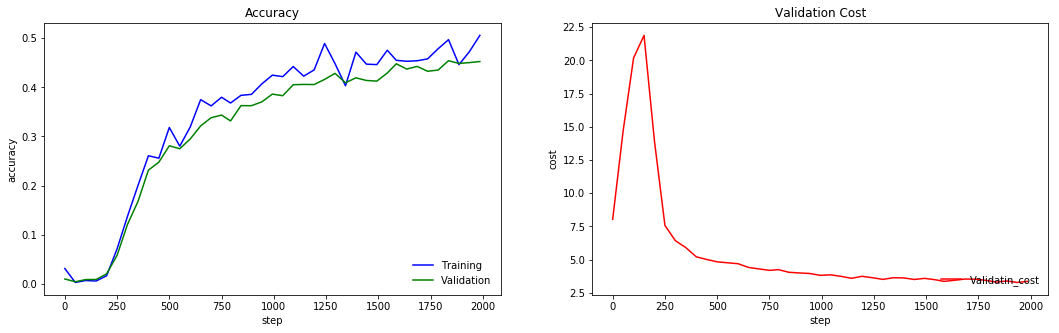

In [20]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('Accuracy')

plt.subplot(122)
plt.plot(x_range, val_costs,'-r', label='Validatin_cost')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('cost')
plt.xlabel('step')
plt.title('Validation Cost')
plt.show()

# test 

In [15]:
# restore model
if 'sess' in globals(): sess.close()
sess = tf.InteractiveSession()

ckpt_path = './small_model/small'
saver.restore(sess, ckpt_path+'-18215')

INFO:tensorflow:Restoring parameters from ./small_model/small-18215


In [18]:
%%time
X_fw_test = X_fw_val
X_bw_test = X_bw_val
Xm_test = Xm_val
Xp_test = Xp_val
Y_test = Y_val

Wall time: 0 ns


In [19]:
from math import ceil

# 여기서도 OOM 날수 있다
acc_tot = []
cost_tot = []
cate_predicted = []
chunk_size = 10000 # OOM 방지
iter_num = ceil(len(Y_test)/chunk_size)

for i in range(iter_num):
    test_accuracy, test_cost, tokens = \
        sess.run([accuracy, cost, predicted], feed_dict={X_fw:X_fw_test[chunk_size*i:chunk_size*(i+1)], X_bw:X_bw_test[chunk_size*i:chunk_size*(i+1)], Xm:Xm_test[chunk_size*i:chunk_size*(i+1)], Xp:Xp_test[chunk_size*i:chunk_size*(i+1)], Y:Y_test[chunk_size*i:chunk_size*(i+1)], keep_prob:1, is_training:False})
    acc_tot.append(test_accuracy)
    cost_tot.append(test_cost)
    
    for tok in tokens:
        cate_predicted.append(token_to_cate[tok].split('>'))
    print('Test Accuracy: %g \tTest cost: %g' %(test_accuracy, test_cost))
    
print('Total Accuracy:', np.array(acc_tot).mean(), '\tTotal Cost:', np.array(cost_tot).mean())

Test Accuracy: 0.575379 	Test cost: 2.37905
Total Accuracy: 0.5753787 	Total Cost: 2.3790514


In [20]:
# 분류 계층별 정확도 보기

# 나누기
cate_ans = []
for i in np.argmax(Y_test, axis=1):
    cate_ans.append(token_to_cate[i].split('>'))


cate_predicted = np.array(cate_predicted)
cate_ans = np.array(cate_ans)

# df_cate = pd.DataFrame(cate_predicted, columns=['bcateid', 'mcateid', 'scateid', 'dcateid'])
# 계산하기
cols=['bcateid', 'mcateid', 'scateid', 'dcateid']
aws_list = cate_ans.transpose([1,0]) == cate_predicted.transpose([1,0])
accs = []

for i, aws in enumerate(aws_list):
    _sum = np.sum(aws)
    acc = _sum/len(aws)
    accs.append(acc)
    print('%s: %g \t %d/%d' %(cols[i], acc, _sum, len(aws)))
    
print('final score:', (accs[0]+accs[1]*1.2+accs[2]*1.3+accs[3]*1.4)/4) 
print('아직 결측치 보정은 안함')

bcateid: 0.843111 	 7013/8318
mcateid: 0.771219 	 6415/8318
scateid: 0.621063 	 5166/8318
dcateid: 0.950589 	 7907/8318
final score: 0.976695119018995
아직 결측치 보정은 안함


In [62]:
# 결측치 보정
sid = Counter(df['scateid'])
sratio = (len(df['scateid']) - sid.get(-1))/len(df['scateid'])
np.array(acc_tot).mean()/sratio

0.7073726530058878

---
0.002 --> 0.86 어닐링 없이
 - 최고 정확도

### 할일
- 텐서보드 붙이기
- ~~모델 저장하기~~
- ~~이니셜라이저 사용~~
- 4가지 레이블 맞추기
    - 점수 제작 코드
- ~~대분류당 중분류 중복 안되는지~~
    - 패턴먼저 파악하기
    - 중복 안되면 강제로 CRF적용가능
    - 중복 안됨
- 모듈화
    - myUtils.py 에 정리하기
    
---
데이터가 1,2와 3이 많이 다르네
 - 훈련 지속할 파이프라인 구축이 우선
 - 배치놈 반드시 필요할듯
    